## Credit Card - ATM Usage Analysis

#### It could be observed the usage of credit cards in ATMs has reduced when comparing the forecasted to actual usage of ATMs, post demonetization

### Imports, Constants, Parameter Settings

In [1]:
### Constants & Imports
import bs4
from bs4 import BeautifulSoup
import requests
import urllib
import urllib3
import re
import os
import wget
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
import itertools
from dateutil.relativedelta import relativedelta
import numpy as np
#DATA_PATH = "/Users/apple/Gdrive/Term1/PRAT/ATMPOS/"
#OUT_PATH = "/Users/apple/Gdrive/Term1/PRAT/"
DATA_PATH='D:/iCloudDrive/ISB/Term1/PRAT/ATMPOS/'
DATA_TEMP_PATH='D:/TEMP/'
OUT_PATH='D:/iCloudDrive/ISB/Term1/PRAT/'
warnings.filterwarnings("ignore")


### Data Processing:
* An automated tool was developed to extract all the ATM/POS grand totals for Debit & Credit Cards from the excel documents
* All the collected data was stored in the form of dataframe & an output CSV file for further references
* Challenges faced:
    + Data format was not consistent for a few documents
        + Certain documents had multiple sheets
        + Additional text/legends were added
        + Data was not always starting at the same positions
        + Cells were merged in some docs, and it was not at some places
    + Few instances,where certain docs had multiple sheets - manually the excels (~3 documents) had to be manually cleansed. Otherwise the documents were automatically handled

In [2]:
os.chdir(DATA_PATH)
i=0
files = os.listdir()
df2 = pd.DataFrame(columns=['Date', 'pos_cc', 'atm_cc', 'pos_dc', 'atm_dc'])
for file_name in files:
    xl = pd.ExcelFile(file_name)
    sheet1=xl.sheet_names
    df1 = xl.parse(sheet1[0])
    if pd.isna(str(df1.iloc[0,0])) & pd.isna(str(df1.iloc[0,1])):
        df1.drop(df.index[0])
        print('Deleted')
    if pd.isna(str(df1.iloc[0,2])):
        x = 2
    else:
        x = 1
    if 'Amount' in str(df1.iloc[x,10]):
        tot_index = 2
        pos_cc = 11
        atm_cc = 10
        pos_dc = 16
        atm_dc = 15
    else:
        tot_index = 1
        pos_cc = 10
        atm_cc = 9
        pos_dc = 15
        atm_dc = 14
    for index, row in df1.iterrows():
        if 'Total' in str(df1.iloc[index,tot_index]):
            if df1.iloc[index,pos_cc]>0:
                month=file_name.split('_')[3].split('.')[0]
                year=file_name.split('_')[2]
                date1=datetime.date(year=int(year),month=int(month),day=int('01'))
                df2.loc[i] = [date1,df1.iloc[index,pos_cc],df1.iloc[index,atm_cc],df1.iloc[index,pos_dc],df1.iloc[index,atm_dc]]
    i=i+1
df2 = df2.sort_values(by='Date')
f_name= os.path.join(str(OUT_PATH),"Output.xlsx")
writer=pd.ExcelWriter(f_name,date_format='dd mm yyyy',options={'remove_timezone': True})
df2.to_excel(writer,"Sheet1")

### Visualizing the Data & Initial Analysis
* In this document, analysis of Credit Cards - ATM Transaction Volume was **only** performed

In [3]:
#df2.index.values
df3=df2[df2['Date'] < datetime.date(int('2016'),int('10'),int('30'))]
df3=df3.set_index(pd.DatetimeIndex(df3['Date']))
decomposition = seasonal_decompose(df3['atm_cc'],freq=12)  


In [4]:
df2.set_index(['Date'],inplace=True)

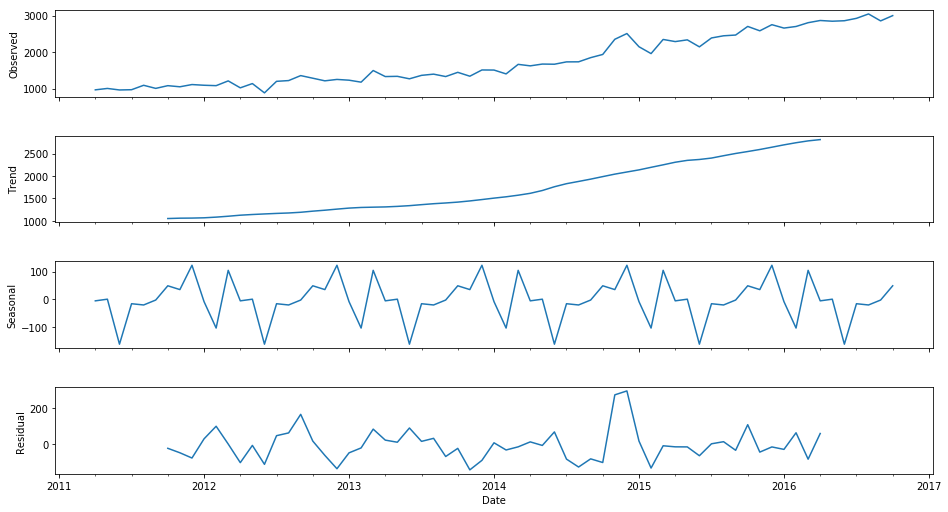

In [5]:
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

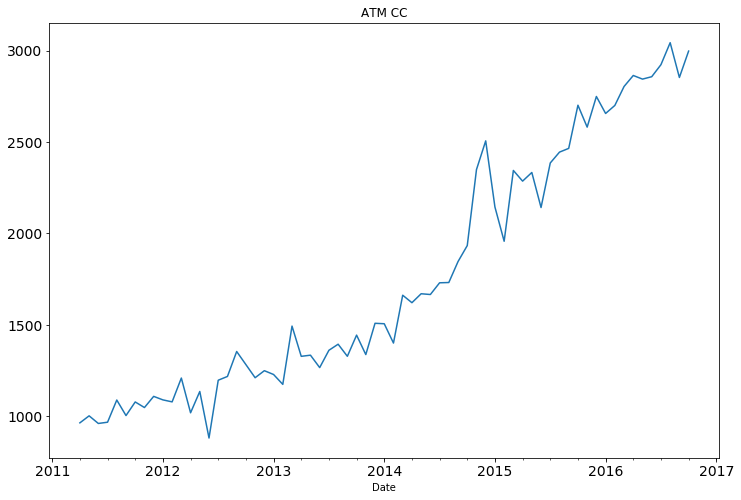

In [6]:
df3.atm_cc.plot(figsize=(12,8), title= 'ATM CC', fontsize=14)

#### ARIMA modelling
* To find the right (pdq) and seasonal (pdq) model triplets that fit the pre-demonetization trend
    + RMSE & AIC values was calculated for the various pdq,seasonal-pdq combinations
    + RMSE & AIC were optimal at **(pdq) = (0, 1, 0) & seasonal-pdq = (1, 1, 0, 12)**

> Credit: https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3
>
> Code was customized to include RMSE to find the best fitting (p,d,q) & seasonal (p,d,q) triplets

In [11]:
from sklearn.metrics import mean_squared_error
from math import sqrt

results_atm_cc = pd.DataFrame(columns=['pdq', 'seasonal_pdq', 'aic', 'rmse'])

index_rad=0

p = d = q = range(0, 2)

pdq = list(itertools.product(p, d, q))

seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df3['atm_cc'],
                                            order=param,trend='n',
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()
            df3['forecast_atm_cc'] = results.predict(start='2015-10-01',dynamic=True)  
            rmse = sqrt(mean_squared_error(df3['2015-10-01':]['atm_cc'], df3['2015-10-01':]['forecast_atm_cc']))
            print('ARIMA{}x{}12 - AIC:{} - RMSE:{}'.format(param, param_seasonal, results.aic,rmse))
            results_atm_cc.loc[index_rad] = [param,param_seasonal,results.aic,rmse]
            index_rad = index_rad+1
        except:
            print('Is this failing??')
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1185.4801580555218 - RMSE:2815.743719101804
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:927.223073579315 - RMSE:1746.0724429303327
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:817.6997009221908 - RMSE:605.1738566680767
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:623.0774354990436 - RMSE:360.12027595109373
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:752.4593661913849 - RMSE:201.6839218930296
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:718.4559341079081 - RMSE:141.02269087312504
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:626.6120838152717 - RMSE:302.60594446911574
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:603.1966119950043 - RMSE:241.09484386359566
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1091.8095158295798 - RMSE:2732.745475510657
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:855.2679694355553 - RMSE:1576.4813965323078
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:764.8630547865332 - RMSE:550.7734059353846
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:593.0586728353254 - RMSE:377.04179725182206
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 -

In [13]:
results_atm_cc = results_atm_cc.sort_values('rmse')
results_atm_cc.head(5)

,pdq,seasonal_pdq,aic,rmse
36,"(1, 0, 0)","(1, 0, 0, 12)",697.697360,87.313753
41,"(1, 0, 1)","(0, 0, 1, 12)",678.518096,88.408557
22,"(0, 1, 0)","(1, 1, 0, 12)",538.352944,88.486104
33,"(1, 0, 0)","(0, 0, 1, 12)",700.417496,89.254268
54,"(1, 1, 0)","(1, 1, 0, 12)",528.030730,89.359724


In [14]:
mod = sm.tsa.statespace.SARIMAX(df3['atm_cc'],
                                order=(1, 1, 0),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

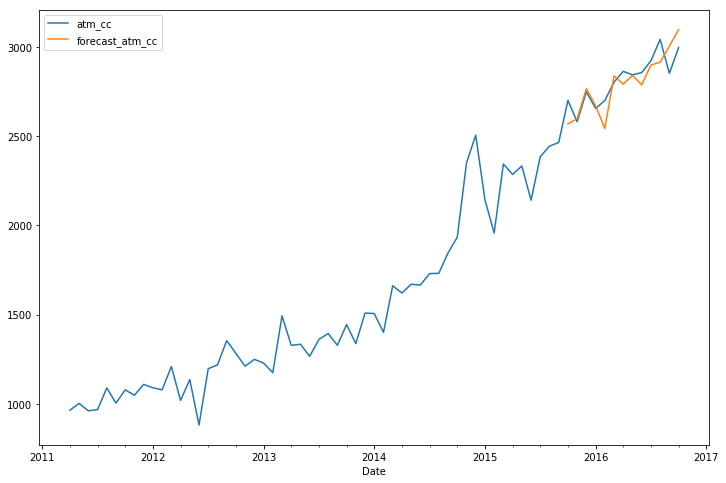

In [15]:
df3['forecast_atm_cc'] = results.predict(start='2015-10-01',end='2018-01-01',dynamic=True)  
df3[['atm_cc', 'forecast_atm_cc']].plot(figsize=(12, 8)) 

In [16]:
mod = sm.tsa.statespace.SARIMAX(df3['atm_cc'],
                                order=(0, 1, 0),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

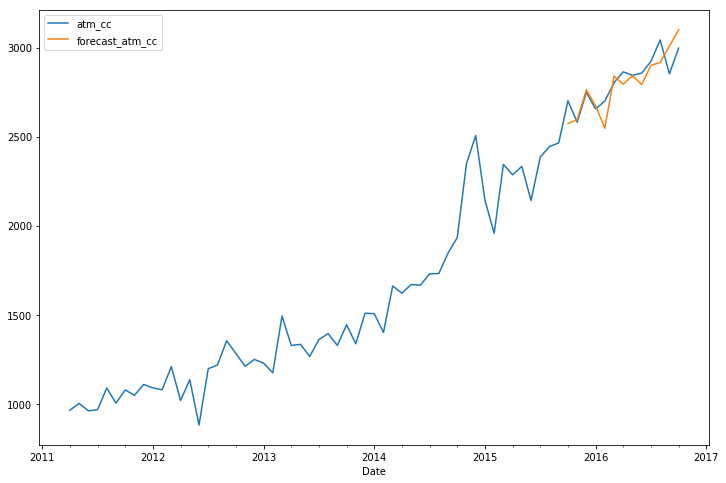

In [17]:
df3['forecast_atm_cc'] = results.predict(start='2015-10-01',end='2018-01-01',dynamic=True)  
df3[['atm_cc', 'forecast_atm_cc']].plot(figsize=(12, 8)) 

In [18]:
start = datetime.datetime.strptime("2016-10-01", "%Y-%m-%d")
date_list = [start + relativedelta(months=x) for x in range(1,18)]
future = pd.DataFrame(index=date_list, columns= df3.columns)
dates_list = [datex.date() for datex in date_list]
future['Date'] = dates_list
df4 = pd.concat([df3, future])

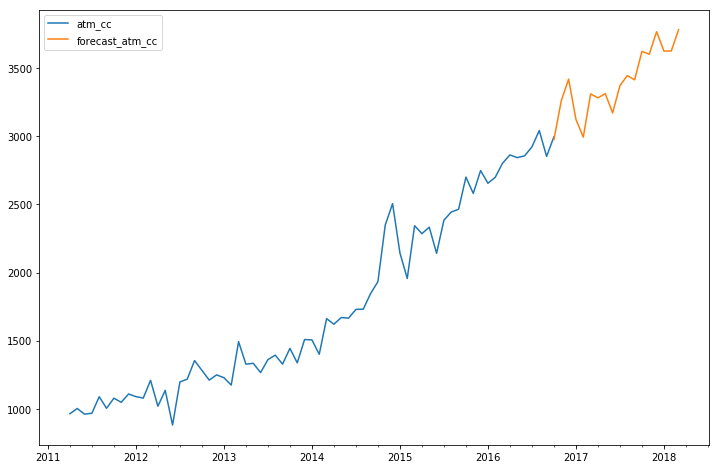

In [19]:
df4['forecast_atm_cc'] = results.predict(start = '2016-10-01', end = '2018-03-01', dynamic= True)  
df4[['atm_cc', 'forecast_atm_cc']].plot(figsize=(12, 8)) 

In [20]:
#df4.set_index(['Date'],inplace=True)
for index, row in df4.iterrows():
    #print(df4.loc[index,'forecast_atm_dc'])
    if np.isnan(df4.loc[index,'forecast_atm_cc']):
        df4.loc[index,'forecast_atm_cc'] = df4.loc[index,'atm_cc']

In [21]:
dfx=df2
#dfx.set_index(['Date'],inplace=True)

In [22]:
merge=pd.merge(df2,df4, how='inner', left_index=True, right_index=True)

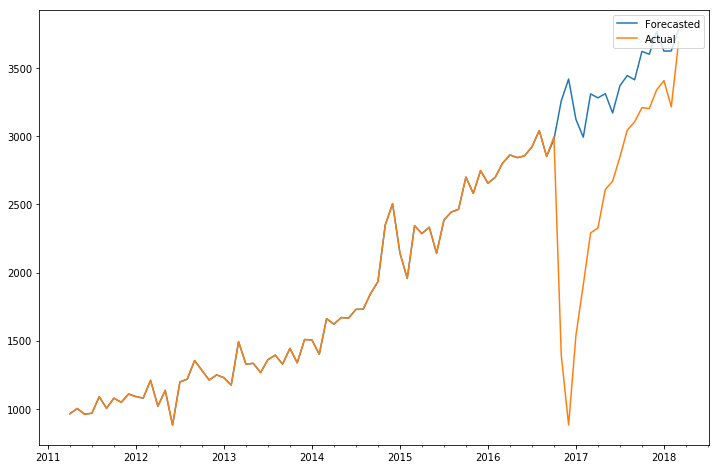

In [24]:
merge['forecast_atm_cc'].plot(figsize=(12, 8),label='Forecasted') 
merge['atm_cc_x'].plot(figsize=(12, 8),label='Actual') 
plt.legend(loc='upper right')
plt.show()


In [30]:
merge['diff'] = merge['atm_cc_x'] - merge['forecast_atm_cc'] 
merge[merge['diff']!=0]['diff']

2016-10-01      20.437272
2016-11-01   -1867.741711
2016-12-01   -2539.429883
2017-01-01   -1585.348789
2017-02-01   -1084.030354
2017-03-01   -1020.370989
2017-04-01    -955.060941
2017-05-01    -704.103016
2017-06-01    -500.759789
2017-07-01    -523.180808
2017-08-01    -400.498667
2017-09-01    -308.437733
2017-10-01    -413.250595
2017-11-01    -398.606102
2017-12-01    -427.617092
2018-01-01    -216.716994
2018-02-01    -410.389220
2018-03-01     -89.398228
Name: diff, dtype: float64